<a href="https://colab.research.google.com/github/haji8-de/AIFFEL_quest_rs/blob/main/Exploration/Ex03/ablation_study_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install torchinfo

In [1]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

In [3]:
# 데이터의 개수도 확인해 봅시다.
train_size = torch.tensor(len(trainset))
test_size = torch.tensor(len(testset))

print(f"Train dataset size: {train_size} (Shape: {train_size.shape})")
print(f"Test dataset size: {test_size} (Shape: {test_size.shape})")

Train dataset size: 50000 (Shape: torch.Size([]))
Test dataset size: 10000 (Shape: torch.Size([]))


In [4]:
# Q. 이미지의 표현이 0과 1 사이로 들어오도록 직접 Pytorch 정규화 코드를 작성해봅시다.
transform = transforms.Compose([
    transforms.ToTensor()  # uint8 → float32 변환 + 0~1 정규화
    # 이미지 픽셀 값을 255로 나누어 0과 1 사이로 정규화하기 위해 transforms.ToTensor()를 사용한다.
])

In [5]:
num_classes = len(trainset.classes)
print(num_classes)

10


In [6]:
class_names = trainset.classes
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [7]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))


In [8]:
def show_multiple_images(dataset, n_images=9):
    dataiter = iter(dataset)
    images, labels = next(dataiter)
    fig, axes = plt.subplots(3, 3, figsize=(6, 6))
    axes = axes.flatten()

    for i in range(n_images):
        ax = axes[i]
        img = imshow(images[i])
        ax.imshow(img)
        ax.set_title(f"Label: {trainset.classes[labels[i]]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

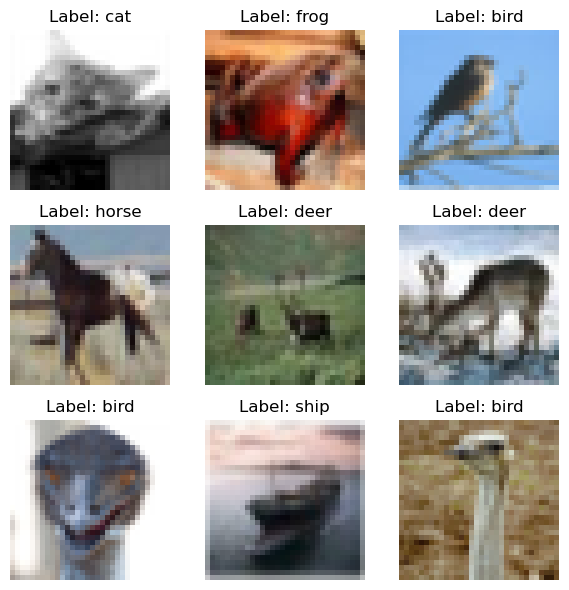

In [9]:
# 학습 데이터셋에서 9개의 이미지를 시각화합니다.
show_multiple_images(trainloader)

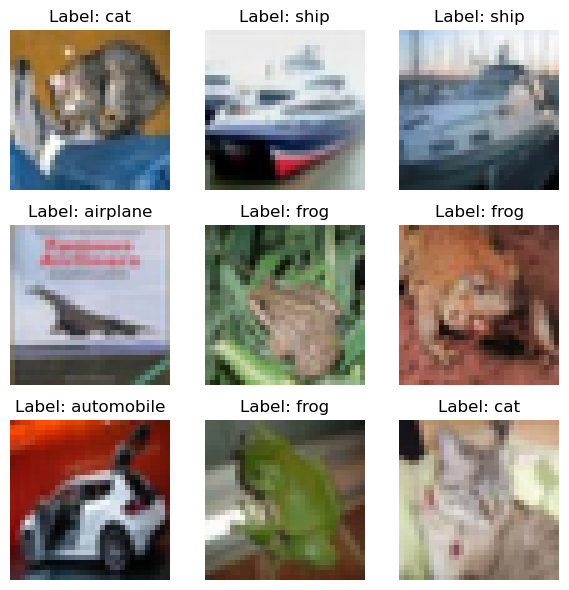

In [10]:
# 테스트 데이터셋에서 9개의 이미지를 시각화합니다.
show_multiple_images(testloader)

In [15]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import models
from torchvision import transforms
from torchvision.datasets import ImageFolder


hyperparams = {
    "batch_size": 4,
    "learning_rate": 0.0001,
    "epochs": 5,
    "transform": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.48235, 0.45882, 0.40784],
                std=[0.229, 0.224, 0.225],
            ),
        ]
    ),
}

In [16]:
from torch import nn


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            inplanes, planes,
            kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            planes, planes,
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or inplanes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    inplanes, self.expansion*planes,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [12]:
class BottleneckBlock(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            inplanes, planes,
            kernel_size=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes,
            kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(
            planes, self.expansion*planes,
            kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)
        self.relu = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or inplanes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    inplanes, self.expansion*planes,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [13]:
import torch


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super().__init__()

        self.inplanes = 64
        self.stem = nn.Sequential(
            nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.inplanes),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        ) 
        self.stage1 = self._make_layer(block, 64, layers[0], stride=1)
        self.stage2 = self._make_layer(block, 128, layers[1], stride=2)
        self.stage3 = self._make_layer(block, 256, layers[2], stride=2)
        self.stage4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        layers = []
        layers.append(block(self.inplanes, planes, stride))
        self.inplanes = planes * block.expansion
        for _ in range(num_blocks - 1):
            layers.append(block(self.inplanes, planes, 1))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.stem(x)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

In [18]:
from torchvision import models
from torchinfo import summary


resnet18 = ResNet(BasicBlock, [2, 2, 2, 2], 1000)
resnet34 = ResNet(BasicBlock, [3, 4, 6, 3], 1000)
resnet50 = ResNet(BottleneckBlock, [3, 4, 6, 3], 1000)
resnet101 = ResNet(BottleneckBlock, [3, 4, 23, 3], 1000)
resnet152 = ResNet(BottleneckBlock, [3, 8, 36, 3], 1000)
torch_model = models.resnet34(weights="ResNet34_Weights.IMAGENET1K_V1")

resnet34_info = summary(resnet34, (1, 3, 224, 224), verbose=0)
torch_model_info = summary(torch_model, (1, 3, 224, 224), verbose=0)

print(resnet34_info.total_params)
print(torch_model_info.total_params)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:01<00:00, 77.0MB/s]


21797672
21797672


In [20]:
resnet_50 = build_resnet(input_shape=(32, 32,3), is_50=True)
resnet_50.summary()

NameError: name 'build_resnet' is not defined

In [21]:
resnet50.summary()

AttributeError: 'ResNet' object has no attribute 'summary'

In [23]:
model = resnet50

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=hyperparams["learning_rate"])

In [27]:
for epoch in range(hyperparams["epochs"]):
    cost = 0.0

    for images, classes in trainloader:
        images = images.to(device)
        classes = classes.to(device)

        output = model(images)
        loss = criterion(output, classes)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cost += loss

    cost = cost / len(trainloader)
    print(f"Epoch : {epoch+1:4d}, Cost : {cost:.3f}")

Epoch :    1, Cost : 2.207
Epoch :    2, Cost : 2.072
Epoch :    3, Cost : 1.968
Epoch :    4, Cost : 1.879
Epoch :    5, Cost : 1.811


In [28]:

with torch.no_grad():
    model.eval()

    accuracy = 0.0
    for images, classes in testloader:
        images = images.to(device)
        classes = classes.to(device)

        outputs = model(images)
        probs = F.softmax(outputs, dim=-1)
        outputs_classes = torch.argmax(probs, dim=-1)

        accuracy += int(torch.eq(classes, outputs_classes).sum())

    print(f"acc@1 : {accuracy / (len(testloader) * hyperparams['batch_size']) * 100:.2f}%")

acc@1 : 286.50%


In [29]:
def display_predictions(loader, model, class_names, device, n_images=9):
    dataiter = iter(loader)
    images, labels = next(dataiter) # Get a batch of images and labels

    fig, axes = plt.subplots(3, 3, figsize=(8, 8)) # Create a 3x3 grid for images
    axes = axes.flatten() # Flatten the 2D array of axes for easier iteration

    with torch.no_grad(): # Disable gradient calculation for inference
        for i in range(n_images):
            if i >= len(images): # Ensure we don't go out of bounds if batch size is smaller than n_images
                break

            ax = axes[i]
            img = imshow(images[i]) # Use the helper function to properly display the image
            ax.imshow(img)

            # Get model output for the image
            outputs = model(images[i].unsqueeze(0).to(device)) # Add batch dimension and move to device

            # Get predicted class
            _, predicted = torch.max(outputs.data, 1)

            # Get the class names
            predicted_class_name = class_names[predicted.item()]
            true_class_name = class_names[labels[i]]

            # Set the title with true and predicted labels
            ax.set_title(f"True: {true_class_name}\nPred: {predicted_class_name}", fontsize=10)
            ax.axis('off') # Hide axes ticks

    plt.tight_layout() # Adjust subplot parameters for a tight layout
    plt.show() # Display the plot
     

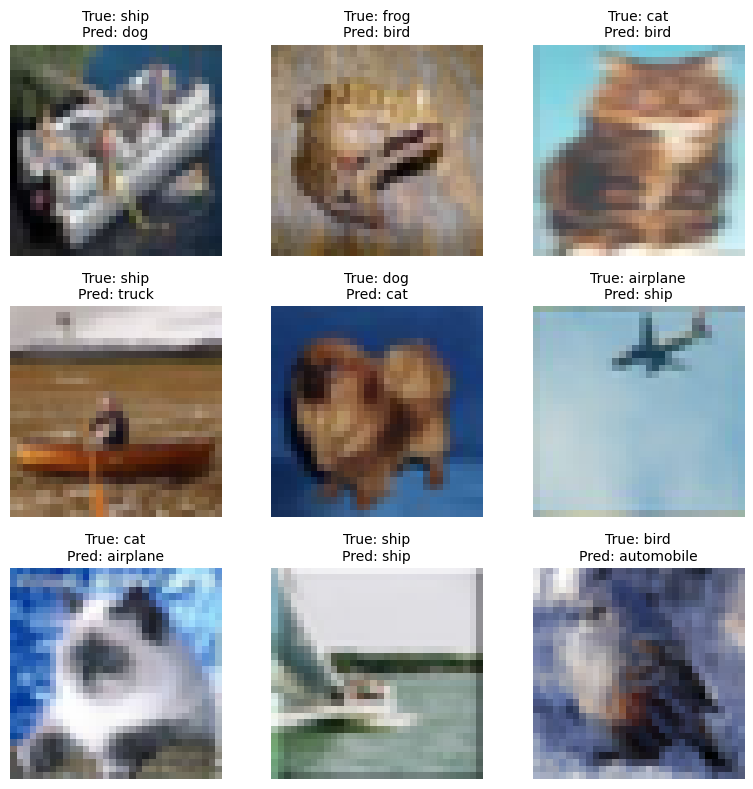

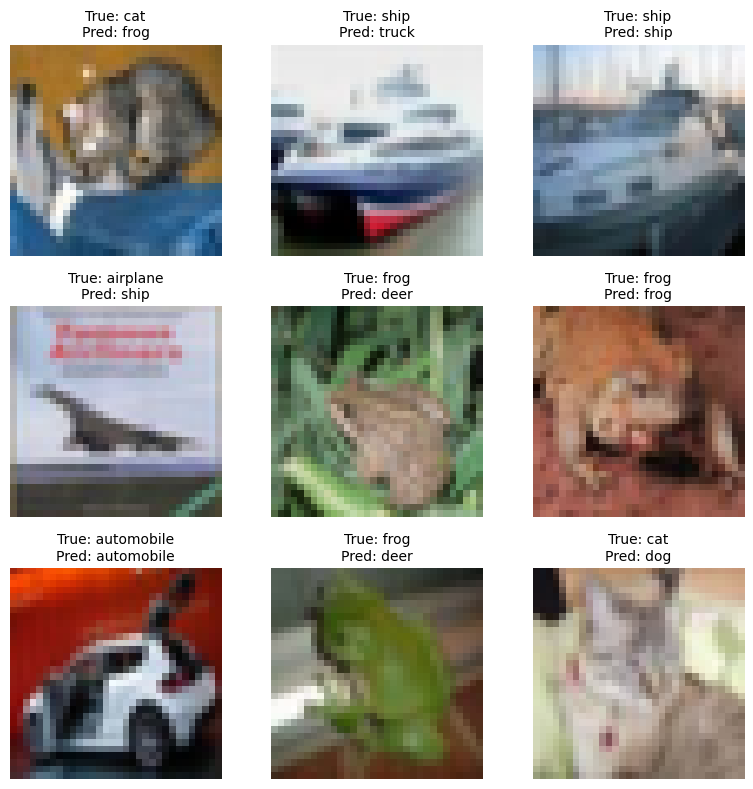

In [33]:

display_predictions(trainloader, model, class_names, device)
display_predictions(testloader, model, class_names, device)